# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)


### Основная цель - найти лучшую модель для определения потенциально уходящих клиентов

**Задачи:**

1) Провести разведочный анализ данных

2) Предобработать данные (пропуски, стандартизация признаков и кодировка)

3) Изучить качество обучения при дисбалансе

4) Изучить качество обучение при сбалансированных классах

5) Выбрать лучшую модель (по F1) и произвести тюнинг её гиперпараметров

6) Дополнительно изучить точность по метрике AUC ROC

# 1. Подготовка данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#загрузим даннные
df = pd.read_csv('/datasets/Churn.csv')

df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Исследуем данные на предмет пропусков:**

In [3]:
 df.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Самое очевидное - посмотреть зависимость между имеющейся у клиента недвижимости и другими признаки. Для этого построим корреляционную матрицу:

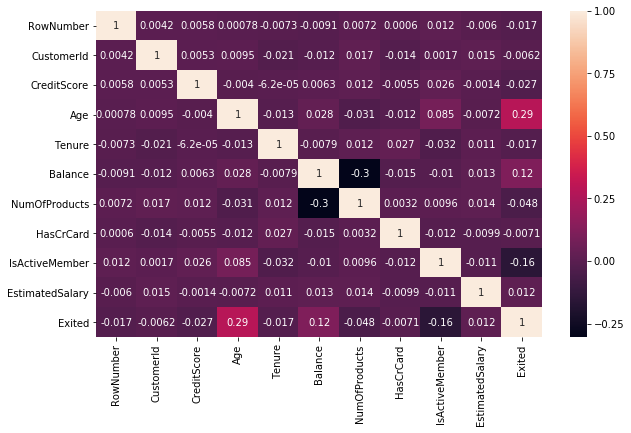

In [4]:
plt.figure(figsize=(10,6))

ax = sns.heatmap(df.corr(method='pearson'), annot=True)

Уточним зависимость от географии:

In [5]:
df.pivot_table(index='Geography', values='Tenure', aggfunc={'count', np.mean, np.median})

,count,mean,median
Geography,,,
France,4550,5.003956,5.0
Germany,2293,4.981247,5.0
Spain,2248,5.001779,5.0


Существенных различий между географией и имеющимся у клиентов имуществов - не обнаружено.

**Таким образом, мы предлагаем заполнить пропущенные значения для данного столбца с помощью среднего.**

In [6]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

**Избавимся от дублирующего индекса строк:**

In [7]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)

# 2. Исследование задачи

Оценим соотношение ушедших клиентов и оставшихся:

In [8]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

**Получили, что признаки соотносятся между собой в пропорции 80 на 20. 
На лицо очевидный дисбаланс между классами.**

Рассмотрим зависимость между признаками и фактом ухода клиента:

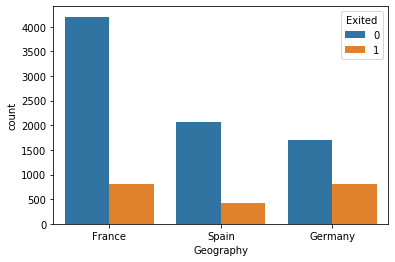

In [9]:
sns.countplot(x='Geography', hue = 'Exited', data=df)

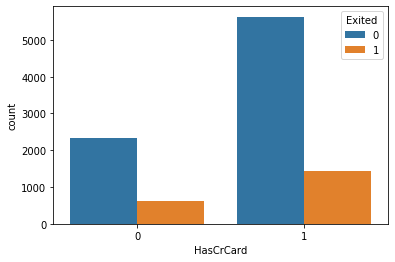

In [10]:
sns.countplot(x='HasCrCard', hue = 'Exited', data=df)

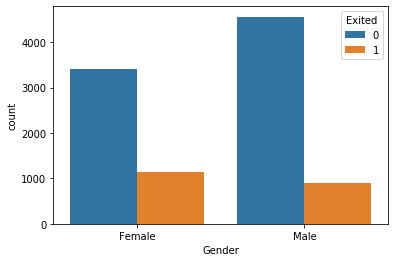

In [11]:
sns.countplot(x='Gender', hue='Exited', data = df)


In [12]:
# массив со столбцами, которые содержат численные признаки
numeric = ['CreditScore','Age','Tenure','Balance','EstimatedSalary','NumOfProducts']

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


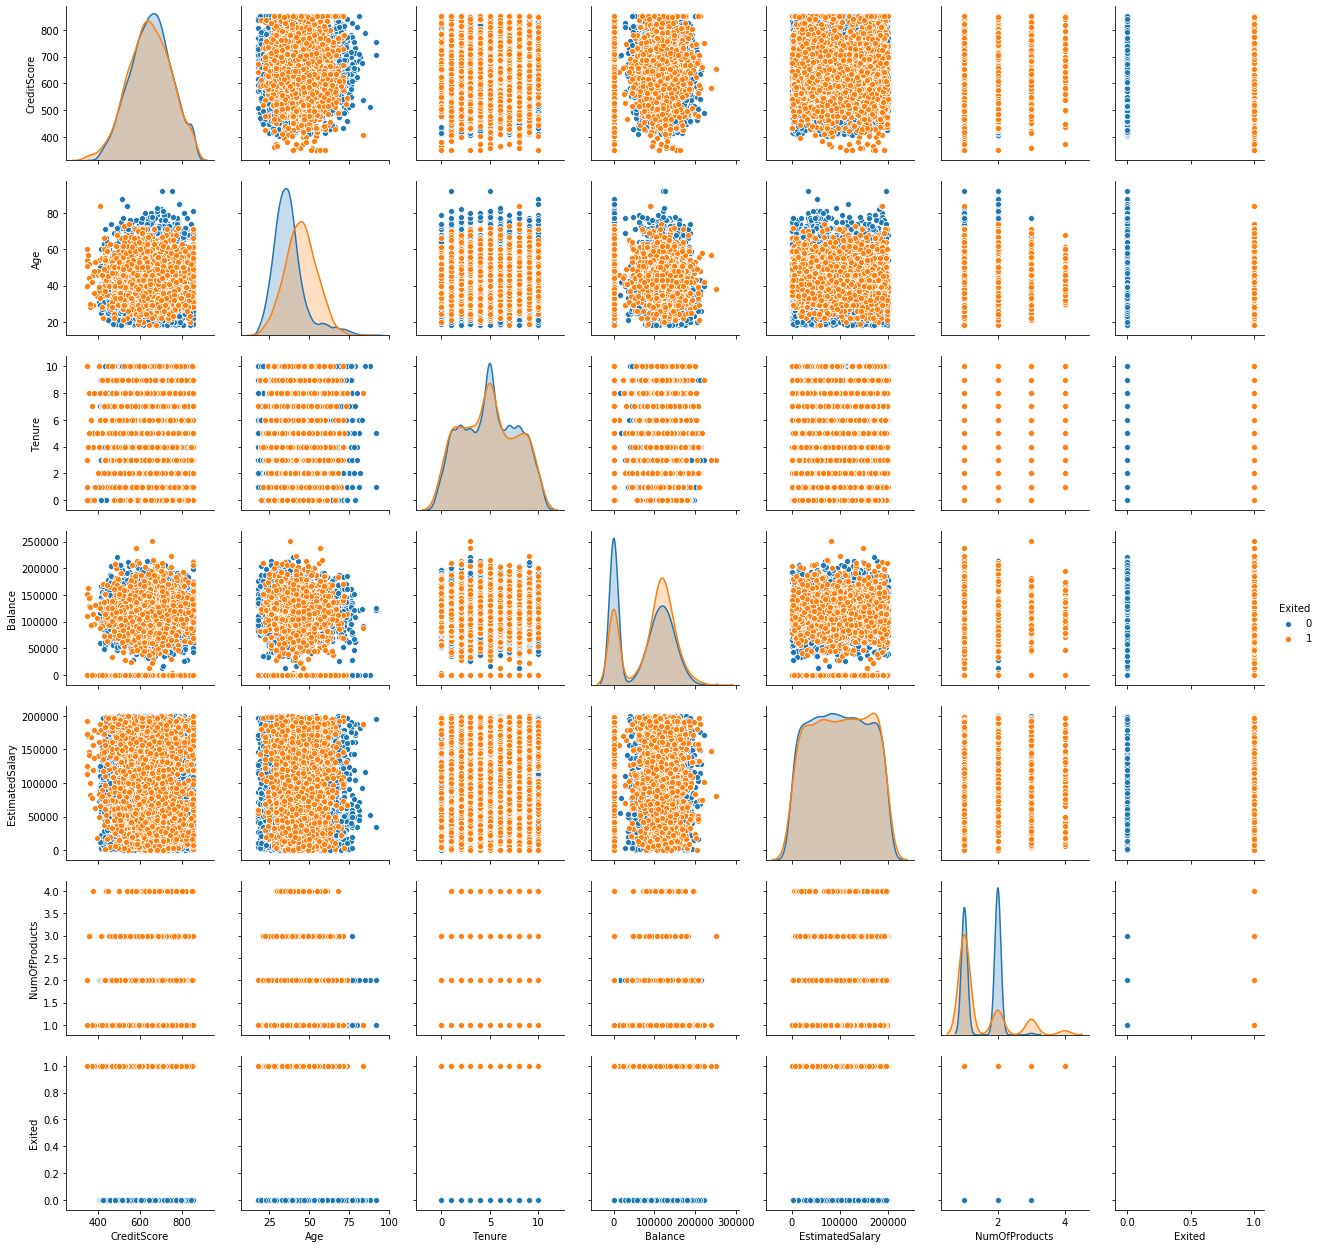

In [13]:
sns.pairplot(df[numeric + ['Exited']] , hue='Exited')

Графики получились немного перегруженными, однако можно заметить, что нет четкого аналитического правила для разбиения ушедших и текущих клиентов по какому-то одному признаку. 

Соответственно, для классификации мы применим алгоритмы машинного обучения.

# Подготовка данных 2

Соберем данные в массивы и стандартизируем шкалы для числовых и категориальных признаков

In [14]:


df = pd.get_dummies(df, drop_first=True)


df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0




***Следующий шаг - разбиение на обучающую, валидационную и тестовую выборку:***

In [15]:
from sklearn.model_selection import train_test_split

X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)



In [16]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2151,753,57,7.0,0.00,1,1,0,159475.08,0,0,1
8392,739,32,3.0,102128.27,1,1,0,63981.37,1,0,1
5006,755,37,0.0,113865.23,2,1,1,117396.25,1,0,0
4117,561,37,5.0,0.00,2,1,0,83093.25,0,0,1
7182,692,49,5.0,110540.43,2,0,1,107472.99,1,0,1


In [17]:
X_train.shape

(8000, 11)

**Стандартизация числовых переменных:**

In [18]:

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

ss.fit(X_train[numeric])

X_train.loc[:,numeric] = ss.transform(X_train[numeric])

X_train.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2151,1.058568,1.715086,0.724999,-1.226059,-0.910256,1,0,1.042084,0,0,1
8392,0.913626,-0.659935,-0.722376,0.413288,-0.910256,1,0,-0.623556,1,0,1
5006,1.079274,-0.184931,-1.807908,0.601687,0.808830,1,1,0.308128,1,0,0
4117,-0.929207,-0.184931,0.001312,-1.226059,0.808830,1,0,-0.290199,0,0,1
7182,0.427035,0.955079,0.001312,0.548318,0.808830,0,1,0.135042,1,0,1


**Обработаем тестовую выборку:**

In [19]:
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5702,585,36,7.0,0.00,2,1,0,94283.09,0,0,1
3667,525,33,4.0,131023.76,2,0,0,55072.93,1,0,1
1617,557,40,4.0,0.00,2,0,1,105433.53,0,1,0
5673,639,34,5.0,139393.19,2,0,0,33950.08,0,1,1
4272,640,34,3.0,77826.80,1,1,1,168544.85,0,1,0


In [20]:
X_test.loc[:,numeric] = ss.transform(X_test[numeric])
X_test.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5702,-0.680735,-0.279932,0.724999,-1.226059,0.808830,1,0,-0.095021,0,0,1
3667,-1.301915,-0.564935,-0.360532,0.877113,0.808830,0,0,-0.778941,1,0,1
1617,-0.970619,0.100072,-0.360532,-1.226059,0.808830,0,1,0.099469,0,1,0
5673,-0.121674,-0.469934,0.001312,1.011458,0.808830,0,0,-1.147374,0,1,1
4272,-0.111321,-0.469934,-0.722376,0.023204,-0.910256,1,1,1.200283,0,1,0


In [21]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 5702 to 3776
Data columns (total 11 columns):
CreditScore          2000 non-null float64
Age                  2000 non-null float64
Tenure               2000 non-null float64
Balance              2000 non-null float64
NumOfProducts        2000 non-null float64
HasCrCard            2000 non-null int64
IsActiveMember       2000 non-null int64
EstimatedSalary      2000 non-null float64
Geography_Germany    2000 non-null uint8
Geography_Spain      2000 non-null uint8
Gender_Male          2000 non-null uint8
dtypes: float64(6), int64(2), uint8(3)
memory usage: 146.5 KB


И последнее - разобьем выборку на обучающую и валидационную

***Комментарий: можно было бы использовать кроссвалидацию и гридсерч, однако цель данного проекта другая. А с K-fold мы уже работали в прошлом проекте***

***Комментарий 2: используем кроссвалидацию модели***

## Сразу проверим адекватность

Зададим исходную точку - попробуем классифицировать наши данные с помощью **DummyClaffisifier** со стратифицированной стратегией - 20% ответов заполним 1 (уход клиента), 80% - не ушел

In [22]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
# создаем объект
dummy_clf = DummyClassifier(strategy='stratified')

dummy_clf.fit(X_train, y_train)
pred = dummy_clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1593
           1       0.22      0.20      0.21       407

    accuracy                           0.69      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.68      0.69      0.69      2000



Выдаваемая характеристика дает accuracy в 70%, а f1-score по целевому классу (1) - 21>


***Попробуем обучить различные модели машинного обучения для наших данных при помощи кроссвалидации и проверим их на GridSearchCV:***


Наиболее многообещающими выглядят модели групп:

**Простые:**

    - Дерево решений (просто и легко интерпретируемое решение)

    - Линейная регрессия


**Сложные:**

    - Случайный лес

    - Градиентный бустинг

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

Создадим словарь для хранения параметров наших моделей:

In [24]:
model_params1 = {
    'decision_tree':{
        'model': DecisionTreeClassifier(max_features = 'auto', random_state=42),
        'params':{
            'max_depth' : [3, 5, 7, 10]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(random_state = 42), 
        'params' : {
            'n_estimators': [20,60, 100, 150, 200],
            'max_depth' : [3,5,7,10] # выставим диапазон вариаций для отдельных деревьев по лучшим из теста предыдущей модели
            
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(class_weight={0 : 1, 1 : 4}, solver='liblinear', random_state=42),
        'params': {
            'C': [1,5,10],
        }
    },
    'gradient_boosting' : {
    'model' : GradientBoostingClassifier(random_state = 42),
    'params': {
       'n_estimators': [20, 60, 100, 150, 200],
       'max_depth':[3,5,7,10]
        }
    }
}

Пробежим по сетке на тренировочной выборке с кросс-валидацией, чтобы определить лучшую модель

In [25]:
scores = []

for model_name, mp in model_params1.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# Пушим массив массивов в DataFrame и выводим на экран
result = pd.DataFrame(scores,columns=['model','best_score','best_params'])
result

,model,best_score,best_params
0,decision_tree,0.840375,{'max_depth': 5}
1,random_forest,0.861125,"{'max_depth': 10, 'n_estimators': 150}"
2,logistic_regression,0.703250,{'C': 5}
3,gradient_boosting,0.863250,"{'max_depth': 3, 'n_estimators': 100}"


Теперь стоит попробовать изучить проблему дисбаланса классов и посмотреть на показатели моделей при сбалансированной обучающей выборке

# 3. Борьба с дисбалансом

Оценим дисбаланс на обучающей и тестовой выборке:

In [26]:
from collections import Counter

counter = Counter(y_train)

disbal = counter[1]/counter[0]
print(f'Изначальное распределение классов: {counter}\nОтношение целевого класса к мажоритарному = {disbal}')


Изначальное распределение классов: Counter({0: 6370, 1: 1630})
Отношение целевого класса к мажоритарному = 0.25588697017268447


Для борьбы с дисбалансом, мы можем применить не совсем стандартную увеличения обучающей выборки - алгоритм SMOTE. Данный метод позволит нам размножить образцы наблюдений минорного класса, основываясь на сходства объектов этого класса между собой (KNeighbors)

**Основное преимущество - мы получим синтетические "промежуточные наблюдения", которые гипотетически могут появиться в тестовой выборке, но они не попали в обучающую выборку. То есть, если просто размножать наблюдения - мы устраним для модели стратегию поведения, близкую к дамми-классификатору, а с применением данного метода - охватим потенциальные ранее неизвестные комбинации целевого класса**

Таким образом, мы изменим структуру обучающей выборки, а также сможем получить синтетические наблюдения для нашей выборки

In [27]:
X_train.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [28]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(random_state=42, categorical_features=[8,9,10])
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
counter_sm = Counter(y_train_sm)
disbal_sm = counter_sm[1]/counter_sm[0]
print(f'Изначальное распределение классов: {counter_sm}\nОтношение целевого класса к мажоритарному = {disbal_sm}')

С помощью данного алгоритма, мы смогли сбалансировать классы, чтобы добиться соотношения 1 к 1.

Попробуем иной алгоритм решения проблемы дисбаланса - adasyn, более сложный чем SMOTE, однако основывающийся на тех же k-neighbors:

In [ ]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(sampling_strategy='minority', n_neighbors = 5)

X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

In [ ]:
counter_ada = Counter(y_train_ada)
disbal_ada = counter_ada[1]/counter_ada[0]
print(f'Изначальное распределение классов: {counter_ada}\nОтношение целевого класса к мажоритарному = {disbal_ada}')

Таким образом, мы сбалансировали классы на обучающей выборке, чтобы улучшить качество обучения.

И двух алгоритмов, мы попробуем использовать adasyn при количестве соседей - 5 (Датафрейм - X_train_ada)

## Подберем наиболее эффективную модель при сбалансированных классах

### В общем-то просто запустим грид-серч для нашей обучающей выборки

In [ ]:
model_params2 = {
    'decision_tree':{
        'model': DecisionTreeClassifier(max_features = 'auto', random_state=42),
        'params':{
            'max_depth' : [3, 5, 7, 10]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(random_state = 42), 
        'params' : {
            'n_estimators': [20,60, 100, 150, 200],
            'max_depth' : [3,5,7,10] # выставим диапазон вариаций для отдельных деревьев по лучшим из теста предыдущей модели
            
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression( solver='liblinear', random_state=42),
        'params': {
            'C': [1,5,10],
        }
    },
    'gradient_boosting' : {
    'model' : GradientBoostingClassifier(random_state = 42),
    'params': {
       'n_estimators': [20, 60, 100, 150, 200],
       'max_depth':[3,5,7,10]
        }
    }
}

In [ ]:
scores_bln = []

for model_name, mp in model_params2.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_ada, y_train_ada)
    scores_bln.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# Пушим массив массивов в DataFrame и выводим на экран
result_bln = pd.DataFrame(scores_bln, columns=['model','best_score','best_params'])
result_bln

Таким образом, нам удалось подобрать параметры моделей, которые должны помочь достичь необходимого уровня точности. Протестируем нашу модель на отложенной выборке.

В сравнении при кроссвалидации, случайный лес показал худший результат при сбалансированных классах, чем не сбалансированных.

# 4. Тестирование моделей

## Сравнение моделей

***Протестируем получившиеся результаты на тестовой выборке для случайного леса и градиентного бустинга как лидеров по оценке на тренировочном кросс-валидационном скоринге:***


### Бустинг на несбалансированных данных



In [ ]:
bst = GradientBoostingClassifier(max_depth=3, n_estimators=100, random_state = 42)

bst.fit(X_train, y_train)

bst_pred = bst.predict(X_test)

print(classification_report(y_test, bst_pred))

### Бустинг на сбалансированных данных

In [ ]:
bst_blc = GradientBoostingClassifier(max_depth=10, n_estimators=150, random_state = 42)

bst_blc.fit(X_train_ada, y_train_ada)

bst_blc_pred = bst_blc.predict(X_test)

print(classification_report(y_test, bst_blc_pred))

- При обучении на сбалансированных данных с помощью AdaBoost градиентный бустинг показал себя хуже.

- Упала как f1 мера, так и accuracy

### Случайный лес на несбалансированных данных

In [ ]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=150, random_state = 42)

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)

print(classification_report(y_test, rfc_pred))

### Случайный лес на несбалансированных данных

In [ ]:
rfc_blc = RandomForestClassifier(max_depth=10, n_estimators=150, random_state = 42)

rfc_blc.fit(X_train_ada, y_train_ada)

rfc_blc_pred = rfc_blc.predict(X_test)

print(classification_report(y_test, rfc_blc_pred))

- Случайный лес показал себя более стабильной моделью по сравнению с бустингом

- На сбалансированных данных упала только accuracy

***Таким образом, мы можем заключить, что градиентный бустинг, обученный на несбалансированных данных, будет являться лучшим выбором, поскольку скоринг характеристики для него являются наивысшими. Данная модель показала точность выше, чем требовалось в задании***



### Теперь исследуем метрику AUC ROC:

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probabilities = bst.predict_proba(X_test)
probabilities_one = probabilities[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one)



In [ ]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC-кривая')
plt.show()

In [ ]:
auc_roc = roc_auc_score(y_test, probabilities_one)
print('Значение метрики AUC-ROC: ', auc_roc)

Таким образом, мы получили, что наша модель показала 87% вероятность определения уходящего клиента (площадь под кривой). Это означает, что мы с высокой долей вероятности сможем удержать клиентов от ухода из банка, параллельно также рассылая предложения тем, кто и не планирует уходить.


## Послесловие: а может всё таки в лес да по дрова?

**Основным преимуществом использования сложных алгоритмом обучения с учителем является более тонкая настройка под обучающую выборку. Основным преимуществом использования алгоритма adasync для балансировки классов являлась гипотетическая возможность получить ранее недоступные комбинации фич и целевого класса на основе ближайших соседей**

***В связи с этим, мы должны попробовать и сравнить ROC-AUC меру для случайного леса, который показал более стабильный результат:***

In [ ]:
probabilities1 = rfc_blc.predict_proba(X_test)
probabilities_two = probabilities1[:, 1]

fpr1, tpr1, thresholds1 = roc_curve(y_test, probabilities_two)

In [ ]:
plt.figure()
plt.plot(fpr1, tpr1)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC-кривая')
plt.show()

In [ ]:
auc_roc = roc_auc_score(y_test, probabilities_two)
print('Значение метрики AUC-ROC: ', auc_roc)

Значение данной метрики уступает качеству работы градиентного бустинга на 2%, соответственно, из-за полученных результатов, мы заключаем, что на этапе отправки, мы должны внести уточнение, что при реализации модели в системе на другом языке - нужно выбрать более простую в реализации модель.

# Выводы

**В ходе нашего исследования мы:**

1) предобработали данные (устранили пропуски в одном столбце, стандартизировали численные переменные, закодировали категориальные)

2) изучали дисбаланс классов и устранили его на обучающей выборке с помощью алгоритма SMOTE и adasync (использовали последний)

3) Протестировали разные модели, по каждой построили отчет по метрике качества работы моделей с помощью перебора гиперпараметров моделей по GridSearchCV

4) Выбрали наилучшую модель  на основе сравнения обученных моделей на сбалансированных и несбалансированных данных

5) Выбрали наилучшую модель - Градиентный бустинг (несбалансированный источник данных для обучения), которая показала f1-меру в 0.61, а метрику AUC-ROC в 0.87 (1-предел качества для обеих метрик). Построили ROC кривую для нашей модели и оценили эффективность по данной метрике

6) Выбрали альтернативную модель - Случайный лес (сбалансированный источник данных для обучения), которая показала f1-меру в 0.59, а метрику AUC-ROC в 0.85. Решение должно применяться с учетом сложности имплементации модели в продашн

***Таким образом, мы смогли построить модель для отдела работы с клиентами, чтобы они могли эффективно отслеживать потенциально уходящих клиентов и предпринимать меры по их удержанию.***
